<a href="https://colab.research.google.com/github/jashvidesai/ORF-Thesis/blob/main/CorrectExponentialVerification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install gurobipy

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def generate_random_parameters(num_nodes, num_vehicles):
    """Generate random parameters for the VRP."""
    V = range(num_nodes)
    np.random.seed()

    # Random distances
    np.random.seed(42)
    distances = np.random.randint(10, 51, size=(num_nodes, num_nodes))
    for i in V:
        distances[i, i] = 0
        for j in range(i + 1, num_nodes):
            distances[j, i] = distances[i, j]
        for j in V:
            for k in V:
                if distances[i, j] > distances[i, k] + distances[k, j]:
                    distances[i, j] = distances[i, k] + distances[k, j]

    # Random demands and pickups
    d = np.random.randint(10, 50, size=num_nodes)
    p = np.random.randint(5, 30, size=num_nodes)

    # Depot has zero demand and pickup
    d[0] = 0
    p[0] = 0

    # Random time windows and service times
    a = np.random.randint(0, 5, size=num_nodes)
    a = a.tolist()
    b = a + np.random.randint(10, 30, size=num_nodes)
    s = np.random.randint(0, 3, size=num_nodes)

    # Vehicle capacities and fixed costs
    Q = np.random.randint(40, 100, size=num_vehicles)
    fixed_costs = np.random.randint(80, 150, size=num_vehicles)

    return distances, d, p, a, b, s, Q, fixed_costs

In [5]:
def solve_vrp(num_nodes, num_vehicles):
    """Solve the VRP for a given set of parameters."""
    try:
        # Generate parameters
        distances, d, p, a, b, s, Q, fixed_costs = generate_random_parameters(num_nodes, num_vehicles)
        vehicle_speed = 60
        t = distances / vehicle_speed  # Travel time matrix
        c = distances * 0.093  # Travel cost matrix

        # Initialize model
        model = gp.Model("CompleteVRP")
        V = range(num_nodes)
        V_star = range(1, num_nodes)
        K = range(num_vehicles)

        # Decision variables
        x = model.addVars(V, V, K, vtype=GRB.BINARY, name="x")
        q = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="q")
        tau = model.addVars(V, K, vtype=GRB.CONTINUOUS, name="tau")
        y = model.addVars(V_star, K, vtype=GRB.CONTINUOUS, name="y")
        z = model.addVars(V_star, K, vtype=GRB.CONTINUOUS, name="z")

        print("a:", a)
        print("b:", b)
        print("tau:", tau)

        # Objective: Minimize travel and fixed costs
        model.setObjective(
            gp.quicksum(c[i, j] * x[i, j, k] for i in V for j in V for k in K if i != j) +
            gp.quicksum(fixed_costs[k] * gp.quicksum(x[0, j, k] for j in V_star) for k in K),
            GRB.MINIMIZE
        )

        # Constraints
        # Constraint 1: each vehicle visited by at least one customer
        model.addConstrs(
            (gp.quicksum(x[i, j, k] for i in V for k in K) >= 1 for j in V_star),
            name="visit_customer_once"
        )

        # Constraint 2: each vehicle departed from by at least one customer
        model.addConstrs(
            (gp.quicksum(x[i, j, k] for j in V for k in K) >= 1 for i in V_star),
            name="departure_from_node_once"
        )

        # Constraint 3: Ensure each vehicle departs the depot at most once
        model.addConstrs(
            (gp.quicksum(x[0, j, k] for j in V_star) == 1 for k in K),
            name="vehicle_depart_depot_once"
        )

        # Constraint 4: Ensure each vehicle returns to the depot at most once
        model.addConstrs(
            (gp.quicksum(x[i, 0, k] for i in V_star) == 1 for k in K),
            name="vehicle_return_depot_once"
        )

        # Constraint 5: Flow Conservation
        model.addConstrs(
            (gp.quicksum(x[i, j, k] for i in V if j != i) == gp.quicksum(x[j, i, k] for i in V if j != i)
            for j in V_star for k in K),
            name="flow_conservation"
        )

        # Constraint 6: No self-loops
        model.addConstrs(
            (x[i, i, k] == 0 for i in V for k in K),
            name="no_self_loops"
        )

        # Constraint 7: Depot load initialization
        model.addConstrs(
            (q[0, k] == 0 for k in K),
            name="depot_load"
        )

        # Constraint 8: q bound
        model.addConstrs(
            (q[i, k] >= 0 for i in V_star for k in K),
            name="load_lower_bound"
        )

        model.addConstrs(
            (q[i, k] <= Q[k] for i in V_star for k in K),
            name="load_upper_bound"
        )

        # Constraint 9: y non-negative
        model.addConstrs(
            (y[i, k] >= 0 for i in V_star for k in K),
            name="y_lower_bound"
        )

        # Constraint 10: z non-negative
        model.addConstrs(
            (z[i, k] >= 0 for i in V_star for k in K),
            name="z_lower_bound"
        )

        # Constraint 11: Dropoff/Delivery feasibility
        model.addConstrs(
            (y[j, k] <= q[i, k] + d[j] * (1 - x[i, j, k])
            for i in V_star for j in V_star for k in K if i != j),
            name="dropoff_feasibility"
        )

        # Constraint 12: Pickup Feasibility
        model.addConstrs(
            (z[i, k] <= Q[k] - (q[i, k] - y[j, k]) + p[i] * (1 - x[i, j, k])
            for i in V_star for j in V_star for k in K if i != j),
            name="pickup_feasibility"
        )

        # Constraint 13: Delivery fulfillment and Pickup fulfillment
        model.addConstrs(
            (gp.quicksum(y[i, k] for k in K) == d[i] for i in V_star),
            name="delivery_fulfillment"
        )

        model.addConstrs(
            (gp.quicksum(z[i, k] for k in K) == p[i] for i in V_star),  # Use 'p' for pickup demand
            name="pickup_fulfillment"
        )

        # Constraint 14: Load Progression 1
        model.addConstrs(
            (q[i, k] - y[j, k] + z[j, k] <= q[j, k] + Q[k] * (1 - x[i, j, k])
            for i in V_star for j in V_star for k in K if i != j),
            name="load_progression_one"
        )

        # Constraint 15: Load Progression 2
        M = {(j, k): d[j] + Q[k] for j in V_star for k in K}

        model.addConstrs(
            (q[i, k] - y[j, k] + z[j, k] >= q[j, k] - M[j, k] * (1 - x[i, j, k])
            for i in V_star for j in V_star for k in K if i != j),
            name="load_progression_two"
        )

        # Constrain 16: Delivery and pickup can only happen if the node is visited
        model.addConstrs(
            (y[i, k] <= d[i] * gp.quicksum(x[j, i, k] for j in V) for i in V_star for k in K),
            name="load_delivery_consistency"
        )

        model.addConstrs(
            (z[i, k] <= p[i] * gp.quicksum(x[j, i, k] for j in V) for i in V_star for k in K),
            name="load_pickup_consistency"
        )

        # Constraint 17 (unchanged): Time Window #1
        model.addConstrs(
            (tau[0, k] == 0 for k in K),
            name="depot_time"
        )

        # Constraint 18 (unchanged): Time Window #2
        model.addConstrs(
            (a[i] <= tau[i, k] for i in V_star for k in K),
            name="time_window_start"
        )

        model.addConstrs(
            (tau[i, k] <= b[i] for i in V_star for k in K),
            name="time_window_end"
        )

        # Constraint 19 (unchanged): Time Window #3
        M_2 = {(i, j, k): b[i] - a[j] + s[i] + t[i, j] for i in V_star for j in V_star for k in K if i != j}
        model.addConstrs(
            (tau[i, k] + s[i] + t[i, j] <= tau[j, k] + M_2[i, j, k] * (1 - x[i, j, k])
            for i in V_star for j in V_star for k in K if i != j),
            name="service_time"
        )

        # Solve the model
        model.optimize()

        # Check feasibility
        if model.status == GRB.OPTIMAL:
            return model.Runtime
        else:
            return None

    except Exception as e:
        print(f"Error: {e}")
        return None

In [12]:
def exponential_func(x, a, b):
    return a * np.exp(b * x)

def run_experiment_with_fit():
    # Experiment parameters
    node_sizes = [5, 6, 7, 8, 9, 10, 11]
    num_vehicles = 3
    num_trials_per_size = 50

    results = []

    for num_nodes in node_sizes:
        print(f"Running experiments for {num_nodes} nodes...")
        successful_trials = 0
        total_trials = 0
        runtimes = []

        while successful_trials < num_trials_per_size:
            runtime = solve_vrp(num_nodes, num_vehicles)
            total_trials += 1
            if runtime is not None:
                runtimes.append(runtime)
                successful_trials += 1

        avg_runtime = np.mean(runtimes)
        results.append(avg_runtime)
        print(f"Nodes: {num_nodes}, Avg Runtime: {avg_runtime:.4f} seconds ({successful_trials}/{total_trials} trials)")

    # Fit the exponential curve to the results
    popt, pcov = curve_fit(exponential_func, node_sizes, results)
    a, b = popt

    # Plot results
    plt.figure(figsize=(8, 6))
    plt.scatter(node_sizes, results, color="blue", label="Data (Avg Runtime)")
    plt.plot(node_sizes, exponential_func(np.array(node_sizes), a, b), color="red", label=f"Fit: y = {a:.3f} * exp({b:.3f} * x)")
    plt.xlabel("Number of Nodes")
    plt.ylabel("Average Runtime (seconds)")
    plt.title("Computation Time vs. Number of Nodes in VRP")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"Fitted Equation: y = {a:.6f} * exp({b:.6f} * x)")

Streaming output truncated to the last 5000 lines.
  RHS range        [1e+00, 1e+02]
Presolve removed 198 rows and 36 columns
Presolve time: 0.03s
Presolved: 1203 rows, 378 columns, 5940 nonzeros
Variable types: 108 continuous, 270 integer (270 binary)

Root relaxation: objective 3.452280e+02, 58 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  345.22800    0   12          -  345.22800      -     -    0s
     0     0  345.65209    0   27          -  345.65209      -     -    0s
H    0     0                     370.8030000  345.65209  6.78%     -    0s
     0     0  346.34400    0   22  370.80300  346.34400  6.60%     -    0s
     0     0  347.46000    0   16  370.80300  347.46000  6.30%     -    0s
H    0     0                     364.5720000  347.46000  4.69%     -    0s
     0     0  347.46000    0   16  364.57200  347.46000  

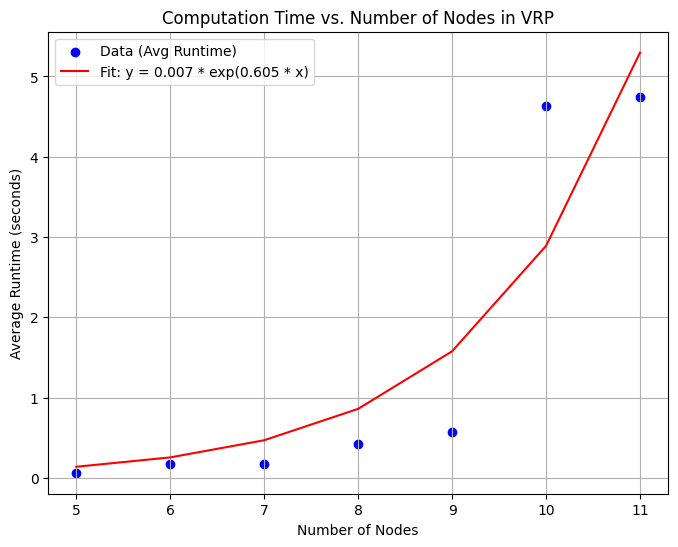

Fitted Equation: y = 0.006786 * exp(0.605422 * x)


In [13]:
run_experiment_with_fit()